In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
sys.path.insert(0, os.path.abspath(os.path.join( os.getcwd(), '..')))
# Import organization

import pandas as pd
from ogb.linkproppred import PygLinkPropPredDataset, Evaluator
import torch 
from matplotlib import pyplot as plt
from visual import load_csv
from torch_geometric import utils
from torch_geometric.utils import to_torch_coo_tensor, coalesce 
import numpy as np
from scipy.sparse import coo_matrix, csr_matrix

from core.heuristic.lsf import CN, AA, RA, InverseRA
from core.heuristic.gsf import Ben_PPR, shortest_path, katz_apro, katz_close, SymPPR
from core.data_utils.load import load_data_lp
from core.data_utils.lcc import use_lcc
from core.graphgps.utility.utils import init_cfg_test
from IPython.display import display, Markdown
from visual import (find_opt_thres, 
                    get_metric_invariant, 
                    load_results, 
                    plot_pos_neg_histogram, 
                    tensor_to_csr_matrix, 
                    eval_mix_heuristic,
                    save_error_examples)

/home/hk-project-test-p0021478/cc7738/anaconda3/envs/TAG-LP/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


   edge_index0  edge_index1      pred   gr
0           26          702  6.421436  1.0
1         2105         2328  2.130622  1.0
2          807         1921  5.570520  1.0
3          159         2095  6.383718  1.0
4          127          603  6.345405  1.0


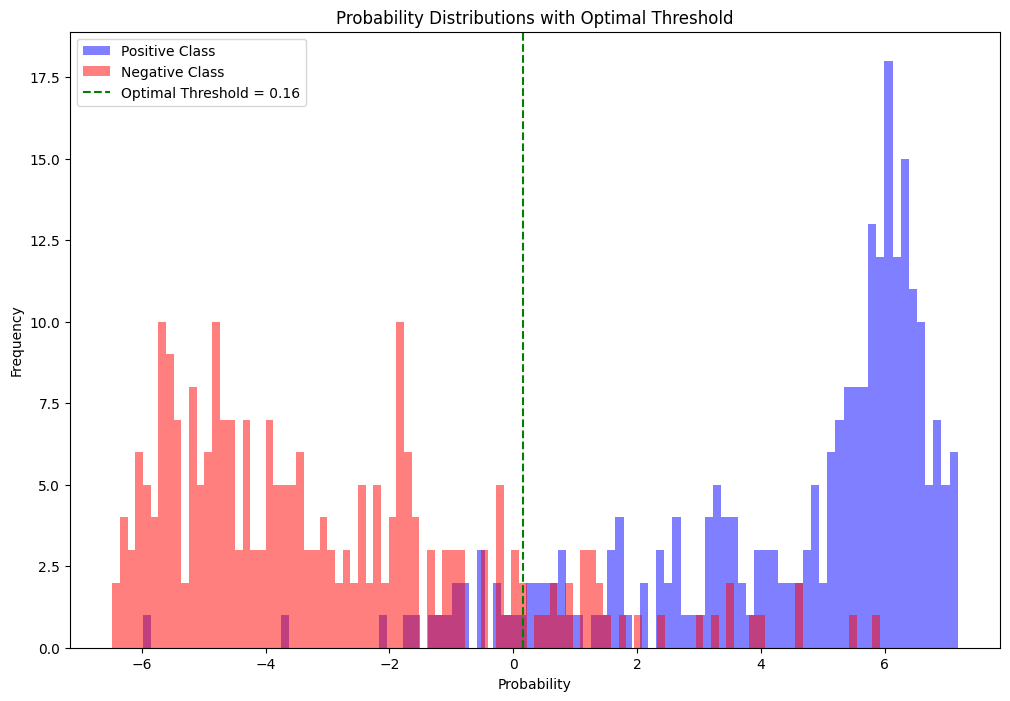

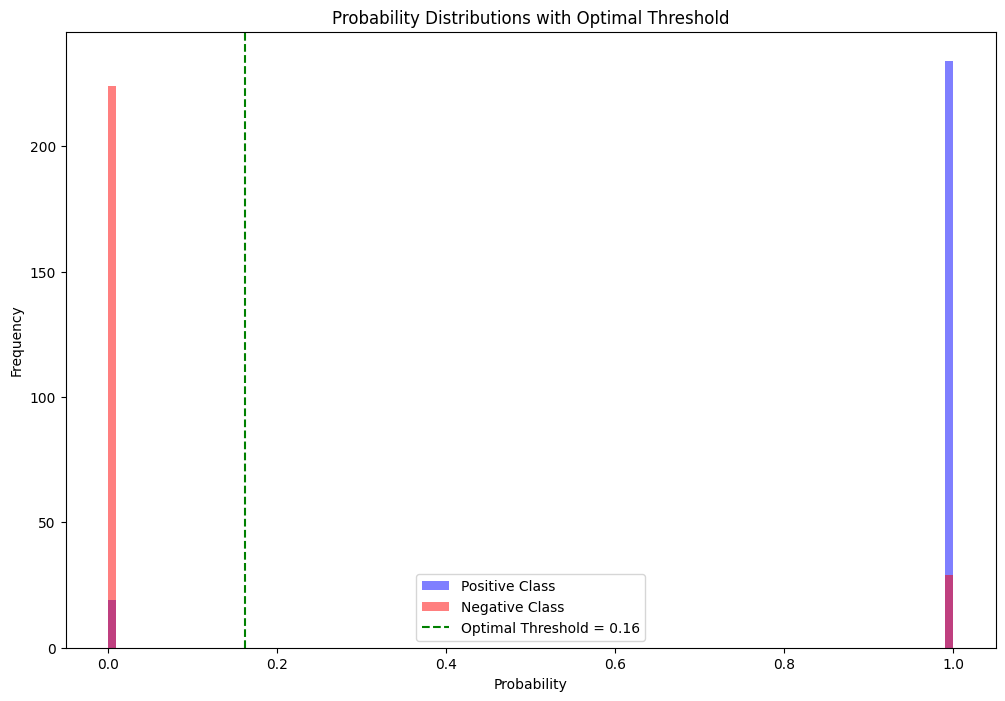

In [2]:
evaluator_hit = Evaluator(name='ogbl-collab')
evaluator_mrr = Evaluator(name='ogbl-citation2')

# Example usage
FILE_PATH = '/hkfs/work/workspace/scratch/cc7738-benchmark_tag/educational_demo/'
ncnc_cora_path = FILE_PATH + 'err_ncnc_llama/ncnc-cora_AUC_0.9669_MRR_0.5275.csv'

P1, P2, pos_index, neg_index = load_results(ncnc_cora_path)
best_thres, best_acc, pos_pred, neg_pred = find_opt_thres(P1, P2)

plot_pos_neg_histogram(P1, P2, best_thres)
plot_pos_neg_histogram(pos_pred, neg_pred, best_thres)



In [3]:
cfg = init_cfg_test()


20it [00:00, 27.18it/s]


<Figure size 640x480 with 0 Axes>

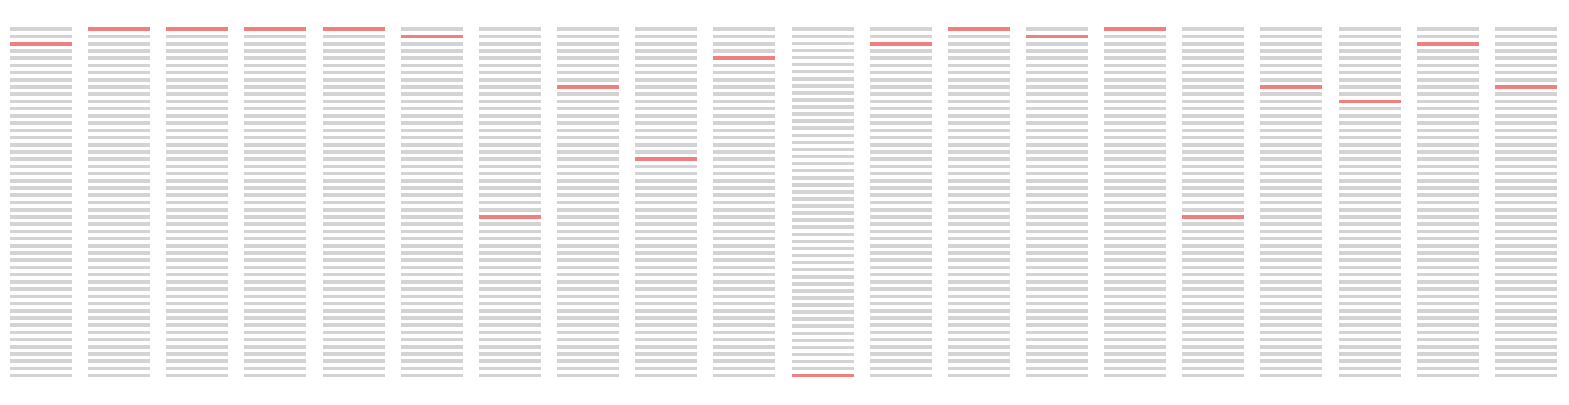

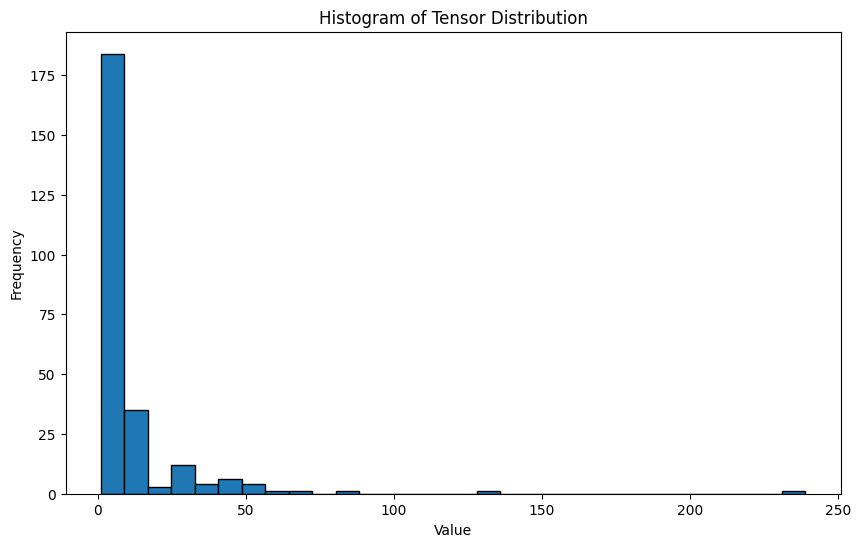

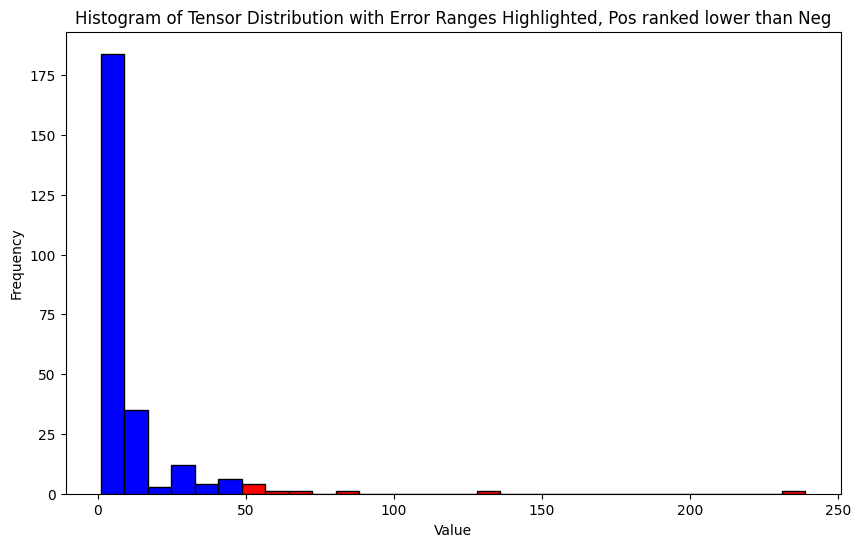

20it [00:01, 18.70it/s]


<Figure size 640x480 with 0 Axes>

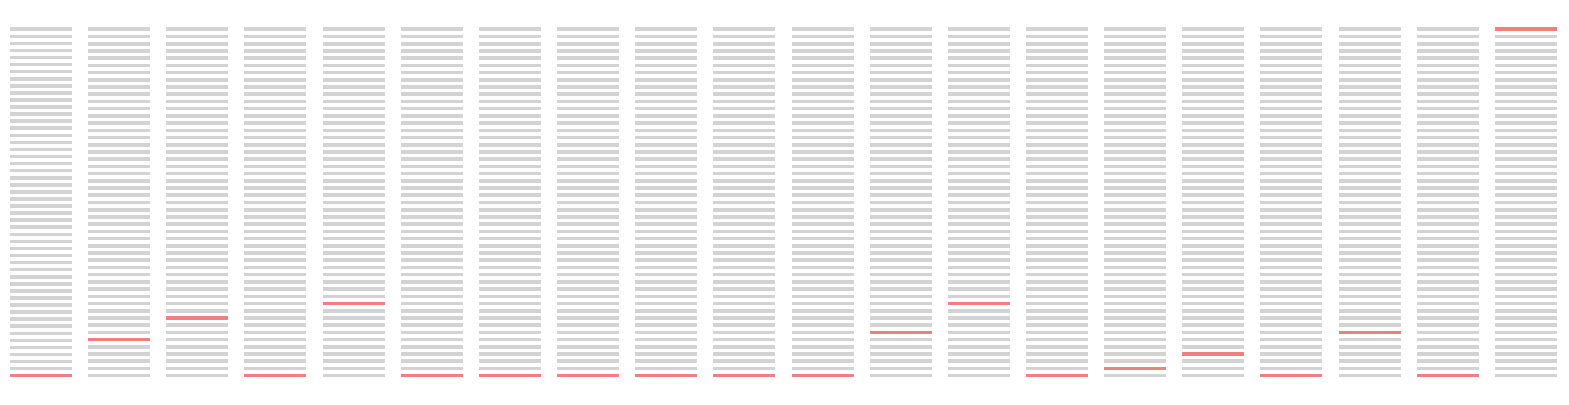

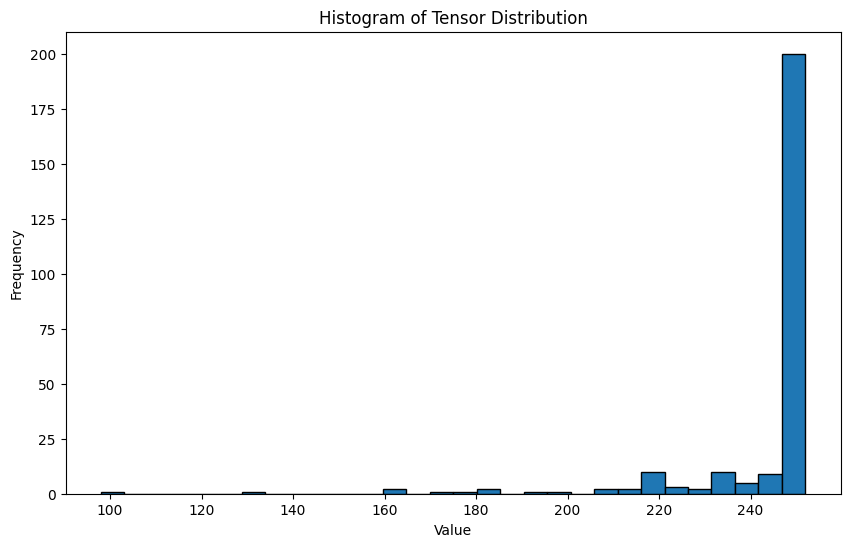

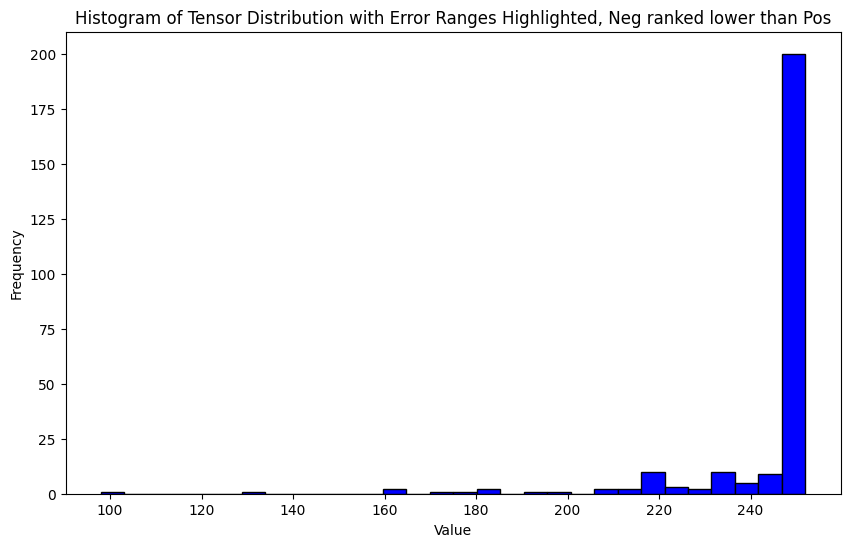

In [4]:
k_list  = [0.1, 0.2, 0.3, 0.5, 1]
mrr_pos2neg, mrr_neg2pos, result_auc_test, pos_edge_index_err, pos_rank_err, neg_edge_index_err, neg_rank_err = get_metric_invariant(P1, pos_index, P2, neg_index, k_list)

not loaded 0 papers.
create graph: 0.1275796890258789
[2485]
original num of nodes: 2485
num of nodes after lcc: 2485
num of edges after lcc: 10138
num of texts in dataset: 2485


100%|██████████| 1/1 [00:00<00:00, 260.71it/s]


evaluated Common Neighbours for 9 edges


100%|██████████| 1/1 [00:00<00:00, 427.25it/s]


evaluated Adamic Adar for 9 edges


100%|██████████| 1/1 [00:00<00:00, 234.11it/s]


evaluated Resource Allocation for 9 edges


100%|██████████| 1/1 [00:00<00:00, 311.61it/s]


evaluated InverseRA for 9 edges


100%|██████████| 9/9 [00:00<00:00, 104.97it/s]

evaluated PPR for 9 edges


remove:  False


100%|██████████| 9/9 [00:00<00:00, 13296.49it/s]


evaluated shortest path for 9 edges
remove:  False


100%|██████████| 9/9 [00:00<00:00, 4573.94it/s]


evaluated katz apro for 9 edges


100%|██████████| 9/9 [00:00<00:00, 27573.95it/s]


evaluated katz close for 9 edges


100%|██████████| 18/18 [00:00<00:00, 168.80it/s]


evaluated SymPPR for 9 edges


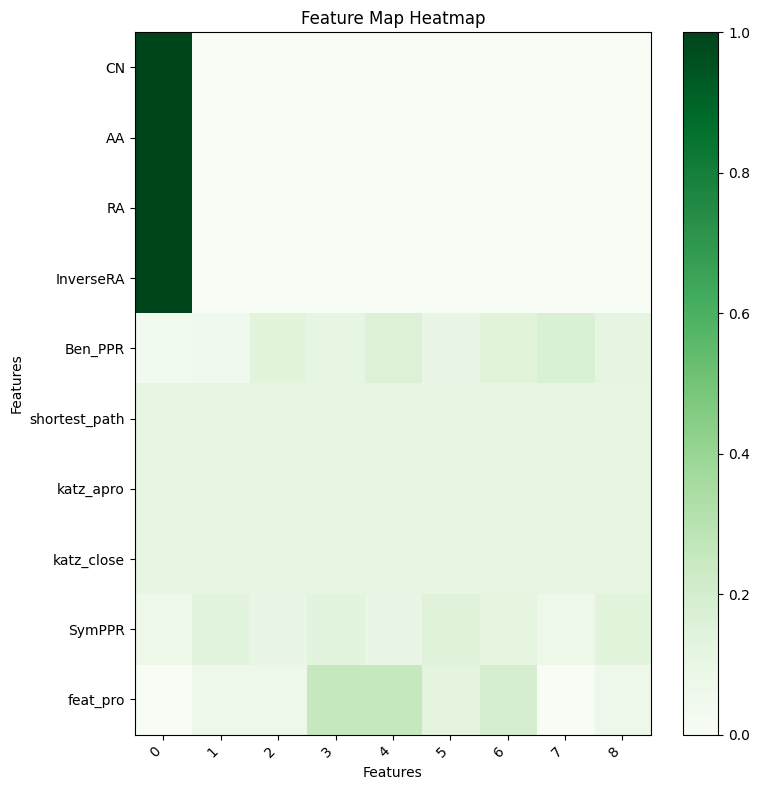

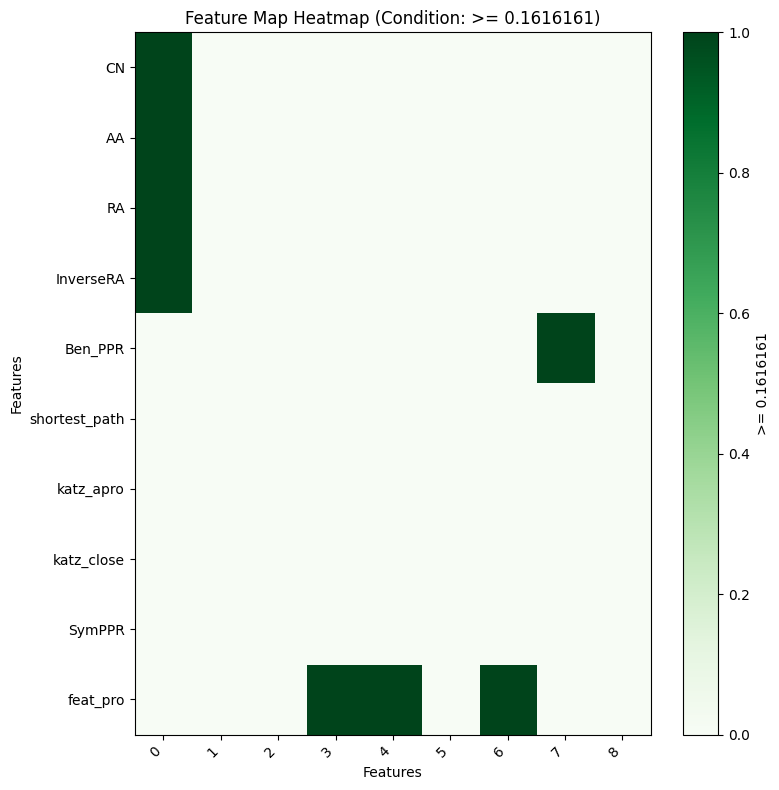

In [5]:
cfg = init_cfg_test()
splits, text, data = load_data_lp[cfg.data.name](cfg.data)

norm_feat_pos = eval_mix_heuristic(data, pos_edge_index_err)
feature_names = ['CN', 'AA', 'RA', 'InverseRA', 'Ben_PPR', 'shortest_path', 'katz_apro', 'katz_close', 'SymPPR', 'feat_pro']
index_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8']
plt.figure(figsize=(8, 8))
plt.imshow(norm_feat_pos, cmap='Greens', aspect='auto')
plt.colorbar()
plt.xticks(ticks=np.arange(len(index_names)), labels=index_names, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(feature_names)), labels=feature_names)
plt.xlabel('Features')
plt.ylabel('Features')
plt.title('Feature Map Heatmap')
plt.tight_layout()
plt.savefig('pos_err_map.png')


condition_value = 0.1616161
bi_err_pos = norm_feat_pos >= condition_value

plt.figure(figsize=(8, 8))
plt.imshow(bi_err_pos, cmap='Greens', aspect='auto')
plt.colorbar(label='>= 0.1616161')  # Label the colorbar to indicate the condition
plt.xticks(ticks=np.arange(len(index_names)), labels=index_names, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(feature_names)), labels=feature_names)
plt.xlabel('Features')
plt.ylabel('Features')
plt.title('Feature Map Heatmap (Condition: >= 0.1616161)')
plt.tight_layout()
plt.show()

100%|██████████| 1/1 [00:00<00:00, 242.94it/s]


evaluated Common Neighbours for 1 edges


100%|██████████| 1/1 [00:00<00:00, 270.97it/s]


evaluated Adamic Adar for 1 edges


100%|██████████| 1/1 [00:00<00:00, 258.86it/s]


evaluated Resource Allocation for 1 edges


100%|██████████| 1/1 [00:00<00:00, 258.14it/s]


evaluated InverseRA for 1 edges


100%|██████████| 1/1 [00:00<00:00, 61.69it/s]


evaluated PPR for 1 edges
remove:  False


100%|██████████| 1/1 [00:00<00:00, 2723.57it/s]


evaluated shortest path for 1 edges
remove:  False


100%|██████████| 1/1 [00:00<00:00, 1431.50it/s]


evaluated katz apro for 1 edges


100%|██████████| 1/1 [00:00<00:00, 4524.60it/s]


evaluated katz close for 1 edges


100%|██████████| 2/2 [00:00<00:00, 154.71it/s]
/hkfs/work/workspace/scratch/cc7738-benchmark_tag/TAPE_chen/analysis/visual.py:426: RuntimeWarning: invalid value encountered in divide
  normalized_feat = heuristic_feat / row_sums


evaluated SymPPR for 1 edges


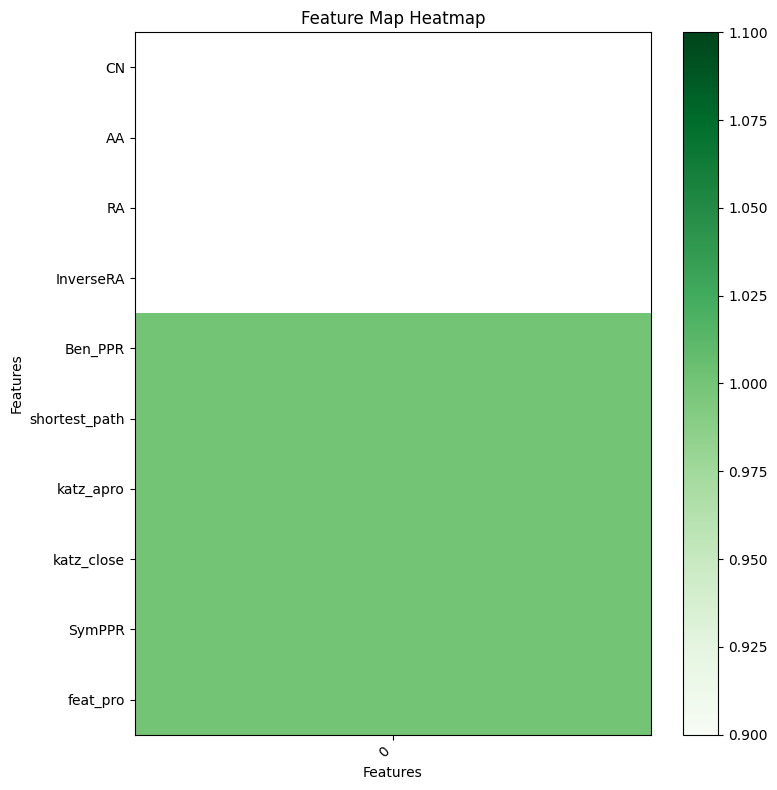

In [6]:
norm_feat_neg = eval_mix_heuristic(data, neg_edge_index_err)
feature_names = ['CN', 'AA', 'RA', 'InverseRA', 'Ben_PPR', 'shortest_path', 'katz_apro', 'katz_close', 'SymPPR', 'feat_pro']
index_names = ['0']
plt.figure(figsize=(8, 8))
plt.imshow(norm_feat_neg, cmap='Greens', aspect='auto')
plt.colorbar()
plt.xticks(ticks=np.arange(len(index_names)), labels=index_names, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(feature_names)), labels=feature_names)
plt.xlabel('Features')
plt.ylabel('Features')
plt.title('Feature Map Heatmap')
plt.tight_layout()
plt.show()
plt.close()

In [7]:
for row in pos_edge_index_err:
    print(f'Source {row[0]}: {text[row[0]][:50]}, \n target {row[1]}: {text[row[1]][:50]}')
    print('-----------------------------------')

Source 573: Title: Interactive Segmentation of Three-dimension, 
 target 675: Title: Parzen. On estimation of a probability dens
-----------------------------------
Source 1311: Title: Support Vector Machines: Training and Appli, 
 target 2484: Title: Human Face Detection in Visual Scenes  
Abs
-----------------------------------
Source 2234: Title: LEARNING MORE FROM LESS DATA: EXPERIMENTS W, 
 target 2333: Title: Clustering Learning Tasks and the Selective
-----------------------------------
Source 851: Title: Learning Concepts from Sensor Data of a Mob, 
 target 1578: Title: Learning Controllers for Industrial Robots 
-----------------------------------
Source 2004: Title: Incremental Class Learning approach and its, 
 target 2383: Title: Learning One More Thing  
Abstract: Most re
-----------------------------------
Source 300: Title: Generalizing from Case Studies: A Case Stud, 
 target 933: Title: Systematic Evaluation of Design Decisions i
-----------------------------------
Sou

In [8]:
for row in neg_edge_index_err:
    print(f'Source {row[0]}: {text[row[0]][:50]}, \n target {row[1]}: {text[row[1]][:50]}')
    print('-----------------------------------')
print('such citation doesnt exist in the dataset')

Source 482: Title: Learning from incomplete data  
Abstract: R, 
 target 702: Title: Cholinergic suppression of transmission may
-----------------------------------
such citation doesnt exist in the dataset


In [9]:
pos_edge_index_err.size()

torch.Size([9, 2])

In [10]:
a = np.array([1, 1, 1, 0, 1, 1, 0, 1, 0])

print(f'after checking only {(a == 1).sum()} pairs are positive.')

after checking only 6 pairs are positive.


In [11]:
type_2 = pos_index[pos_pred == 0]
print(f'{len(type_2)} type 2 errors are detected.')

# type 1 predict yes when no
type_1 = neg_index[neg_pred == 1]
print(f'{len(type_1)} type 1 errors are detected.')


# for row in type_1:
#     src = text[row[0]]
#     tgt = text[row[1]]
#     display(Markdown(f"**Source:** {src}  \n**Target:** {tgt}"))
    
# for row in type_2:
#     src = text[row[0]]
#     tgt = text[row[1]]
#     display(Markdown(f"**Source:** {src}  \n**Target:** {tgt}"))

df = save_error_examples(type_2, text)
print(df.head)
df.to_csv('type_2_errors.csv', index=False)

df = save_error_examples(type_1, text)
print(df.head)
df.to_csv('type_1_errors.csv', index=False)

19 type 2 errors are detected.
29 type 1 errors are detected.
<bound method NDFrame.head of                                                Source  \
0   Title: Using Genetic Algorithms to Explore Pat...   
1   Title: Interactive Segmentation of Three-dimen...   
2   Title: Toward Efficient Agnostic Learning  \nA...   
3   Title: Support Vector Machines: Training and A...   
4   Title: LEARNING MORE FROM LESS DATA: EXPERIMEN...   
5   Title: References elements that can solve diff...   
6   Title: LEARNING BY ERROR-DRIVEN DECOMPOSITION ...   
7   Title: Rerepresenting and Restructuring Domain...   
8   Title: Learning Concepts from Sensor Data of a...   
9   Title: Incremental Class Learning approach and...   
10  Title: A Trade Network Game With Endogenous Pa...   
11  Title: Generalizing from Case Studies: A Case ...   
12  Title: Induction of Multiscale Temporal Struct...   
13  Title: DESIGN AND ANALYSIS OF EFFICIENT REINFO...   
14  Title: Validation of Average Error Rate Over C...

100%|██████████| 1/1 [00:00<00:00, 376.75it/s]


evaluated Common Neighbours for 29 edges


100%|██████████| 1/1 [00:00<00:00, 390.90it/s]


evaluated Adamic Adar for 29 edges


100%|██████████| 1/1 [00:00<00:00, 465.05it/s]


evaluated Resource Allocation for 29 edges


100%|██████████| 1/1 [00:00<00:00, 446.92it/s]


evaluated InverseRA for 29 edges


100%|██████████| 29/29 [00:00<00:00, 171.39it/s]


evaluated PPR for 29 edges
remove:  False


100%|██████████| 29/29 [00:00<00:00, 8001.76it/s]


evaluated shortest path for 29 edges
remove:  False


100%|██████████| 29/29 [00:00<00:00, 2582.04it/s]


evaluated katz apro for 29 edges


100%|██████████| 29/29 [00:00<00:00, 54325.51it/s]


evaluated katz close for 29 edges


100%|██████████| 58/58 [00:00<00:00, 163.43it/s]
/hkfs/work/workspace/scratch/cc7738-benchmark_tag/TAPE_chen/analysis/visual.py:426: RuntimeWarning: invalid value encountered in divide
  normalized_feat = heuristic_feat / row_sums


evaluated SymPPR for 29 edges


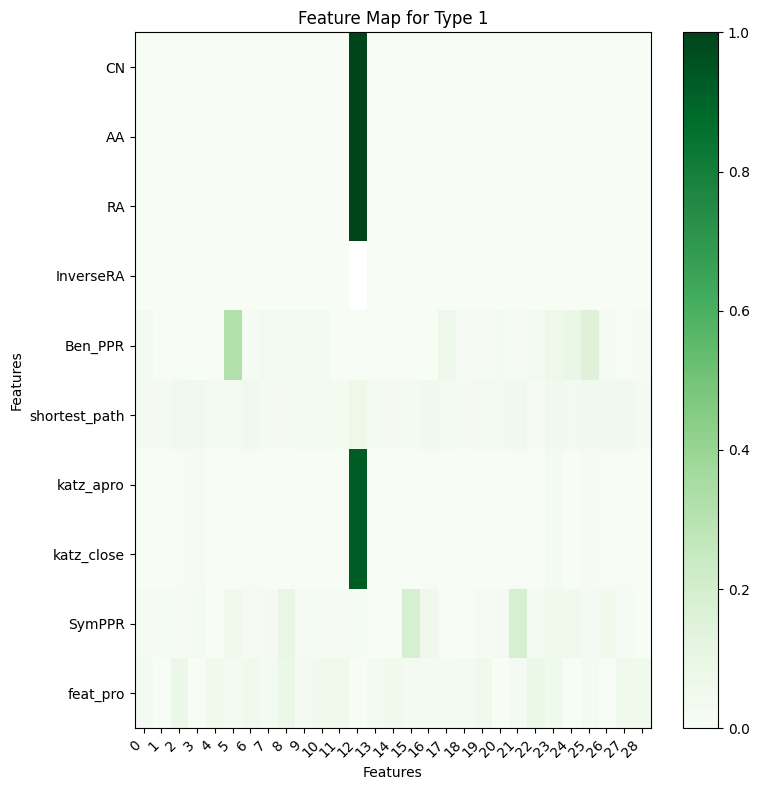

100%|██████████| 1/1 [00:00<00:00, 540.78it/s]


evaluated Common Neighbours for 19 edges


100%|██████████| 1/1 [00:00<00:00, 459.40it/s]


evaluated Adamic Adar for 19 edges


100%|██████████| 1/1 [00:00<00:00, 472.44it/s]


evaluated Resource Allocation for 19 edges


100%|██████████| 1/1 [00:00<00:00, 458.85it/s]


evaluated InverseRA for 19 edges


100%|██████████| 19/19 [00:00<00:00, 160.13it/s]


evaluated PPR for 19 edges
remove:  False


100%|██████████| 19/19 [00:00<00:00, 9942.83it/s]


evaluated shortest path for 19 edges
remove:  False


100%|██████████| 19/19 [00:00<00:00, 2808.12it/s]


evaluated katz apro for 19 edges


100%|██████████| 19/19 [00:00<00:00, 32017.59it/s]


evaluated katz close for 19 edges


100%|██████████| 38/38 [00:00<00:00, 171.56it/s]


evaluated SymPPR for 19 edges


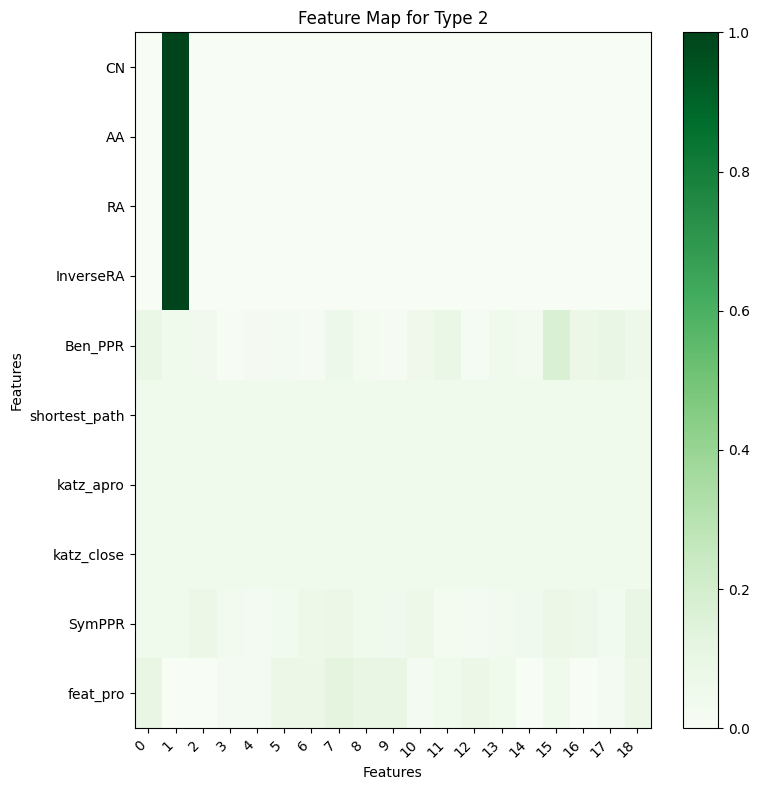

In [12]:
norm_feat_pos = eval_mix_heuristic(data, type_1)
feature_names = ['CN', 'AA', 'RA', 'InverseRA', 'Ben_PPR', 'shortest_path', 'katz_apro', 'katz_close', 'SymPPR', 'feat_pro']
index_names = [str(i) for i in range(type_1.shape[0])]
plt.figure(figsize=(8, 8))
plt.imshow(norm_feat_pos, cmap='Greens', aspect='auto')
plt.colorbar()
plt.xticks(ticks=np.arange(len(index_names)), labels=index_names, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(feature_names)), labels=feature_names)
plt.xlabel('Features')
plt.ylabel('Features')
plt.title('Feature Map for Type 1')
plt.tight_layout()
plt.show()


norm_feat_pos = eval_mix_heuristic(data, type_2)
feature_names = ['CN', 'AA', 'RA', 'InverseRA', 'Ben_PPR', 'shortest_path', 'katz_apro', 'katz_close', 'SymPPR', 'feat_pro']
index_names = [str(i) for i in range(type_2.shape[0])]
plt.figure(figsize=(8, 8))
plt.imshow(norm_feat_pos, cmap='Greens', aspect='auto')
plt.colorbar()
plt.xticks(ticks=np.arange(len(index_names)), labels=index_names, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(feature_names)), labels=feature_names)
plt.xlabel('Features')
plt.ylabel('Features')
plt.title('Feature Map for Type 2')
plt.tight_layout()
plt.show()